In [6]:
import contextily
import geopandas
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import torch
import xarray as xr
from odc.stac import stac_load
from skimage import exposure
from torch.utils.data import DataLoader, IterableDataset, get_worker_info
from xbatcher import BatchGenerator

In [2]:
class CopernicusFMDataset(IterableDataset):
    def __init__(self,
                 xr_dataset,
                 input_dims,
                 input_overlap,
                 verify_fn = None,
                 batch_size_gen=1,
                 ) -> None:
        self.xr_dataset = xr_dataset
        self.input_dims = input_dims
        self.input_overlap = input_overlap or {}
        self.batch_size_gen = batch_size_gen
        self.verify_fn = verify_fn or self.basic_filter

    def create_batch_generator(self, subset):
        return BatchGenerator(
            subset,
            input_dims=self.input_dims,
            input_overlap=self.input_overlap
        )

    def basic_filter(self, patch, threshold=0.05):
        """
        Check if the data contain no_data not more than threshold
        :param patch:
        :type patch:
        :param threshold:
        :type threshold:
        :return:
        :rtype:
        """
        total_elements = patch.size
        num_zeros = np.sum(patch == 0)
        num_nans = np.isnan(patch).sum()
        invalid_fraction = (num_zeros + num_nans) / total_elements
        return invalid_fraction < threshold

    def __iter__(self):
        worker_info = get_worker_info()
        if worker_info is None:
            subset = self.xr_dataset
        else:
            # 🔀 Divide dataset across workers (if possible)
            total_workers = worker_info.num_workers
            worker_id = worker_info.id

             # split across `time` dimension
            time = self.xr_dataset.coords['time']
            split_indices = torch.linspace(0, len(time), total_workers + 1, dtype=torch.int)
            start = split_indices[worker_id].item()
            end = split_indices[worker_id + 1].item()
            subset = self.xr_dataset.isel(time=slice(start, end))

        batch_gen = iter(self.create_batch_generator(subset))
        while True:
            batch_data = []
            while len(batch_data) < self.batch_size_gen:
                try:
                    patch = next(batch_gen).values.squeeze()
                    status = False
                    if self.verify_fn:
                        status = self.verify_fn(patch) # T/F
                    if status:
                        batch_data.append(patch)
                except StopIteration:
                    print("Generator exhausted — stopping batch collection.")
                    if batch_data:  # yield remaining data if any
                        batch_data = np.stack(batch_data, axis=0)
                        yield torch.from_numpy(batch_data).squeeze()
                    return None
            batch_data = np.stack(batch_data, axis=0) # stack the selected patches into batch
            yield torch.from_numpy(batch_data).squeeze()

class CopernicusFMDataModule(L.LightningDataModule):
    def __init__(self,
                 train_xr_dataset,
                 input_dims,
                 input_overlap,
                 verify_fn=None,
                 batch_size_gen=1,
                 num_workers=4):
        super().__init__()
        self.train_xr_dataset = train_xr_dataset
        self.input_dims = input_dims
        self.input_overlap = input_overlap
        self.batch_size_gen = batch_size_gen
        self.verify_fn = verify_fn
        self.train_ds = CopernicusFMDataset(train_xr_dataset,
                                            input_dims=self.input_dims,
                                            input_overlap=self.input_overlap,
                                            verify_fn=self.verify_fn,
                                            batch_size_gen=self.batch_size_gen)

        if num_workers == None:
            self.num_workers = num_workers
        elif num_workers > len(self.train_xr_dataset.coords['time']):
            self.num_workers = len(self.train_xr_dataset.coords['time'])
        else:
            self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            dataset= self.train_ds,
            batch_size=None,
            num_workers=self.num_workers
        )
    def val_dataloader(self):
        pass
    def predict_dataloader(self):
        pass

def get_S2(zarr_store,
           kwargs_search,
           kwargs_load):
        catalog = pystac_client.Client.open("https://stac.dataspace.copernicus.eu/v1/")
        search = catalog.search(collections=["sentinel-2-l2a"], **kwargs_search)
        items = search.item_collection()
        df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs=kwargs_load['crs'])
        print(f'number of detected scenes: {df.shape[0]}')

        items = [item for item in items]
        xx = stac_load(items, groupby='id', **kwargs_load)
        print(f'num of times loaded by stac_load() is {len(xx["time"])}')

        xx.to_zarr(zarr_store,
                   mode="w",
                   consolidated=True,
                   zarr_format=2)
        print('Done get_s2() !')
        return df

def contrast_stretch(rgb, lower=2, upper=98):
    p_low, p_high = np.percentile(rgb, (lower, upper))
    rgb = np.clip((rgb - p_low) / (p_high - p_low), 0, 1)
    return rgb

def z_score_normalisation(ds, mean_dict, std_dict):
    zscore_vars = {}
    for var in ds.data_vars:
        zscore_vars[var] = (ds[var] - mean_dict[var])/std_dict[var]
    return xr.Dataset(zscore_vars)

def percentage_invalid(x):
    x = x.numpy()
    total_elements = x.size
    num_zeros = np.sum(x == 0)
    num_nans = np.isnan(x).sum()
    invalid_fraction = (num_zeros + num_nans) / total_elements
    return invalid_fraction*100

#  Browse the S2 availability from STAC Catalog

Before running this code, please make sure S3 credential of copernicus dataspace has been setup. I recommend you to checkout this following notebook particularly in the S3 Credential section. https://github.com/eu-cdse/notebook-samples/blob/main/geo/stac_filter_prague_snowcover.ipynb

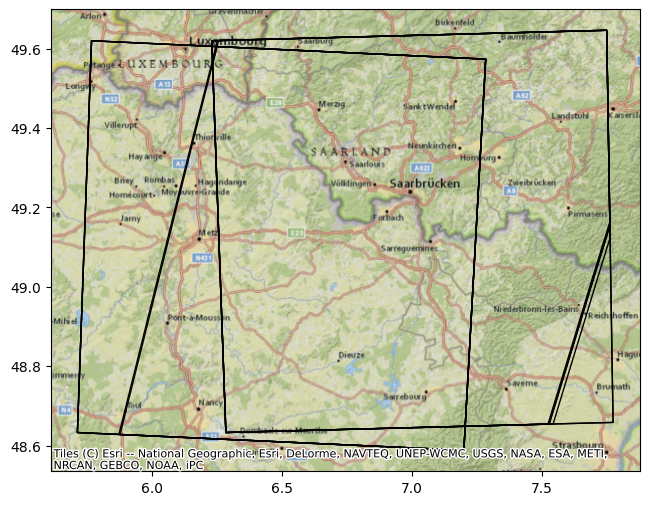

In [3]:
# Browse the S2 availability
catalog = pystac_client.Client.open("https://stac.dataspace.copernicus.eu/v1/")
time_range = "2024-04-01/2024-09-30"
bbox = [6.711273,48.998240,7.216644,49.351072]
query = {"eo:cloud_cover": {"gte": 0, "lte": 5}}
search = catalog.search(collections=["sentinel-2-l2a"],
                        bbox=bbox,
                        datetime=time_range,
                        query= query)
items = search.item_collection()
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
ax = df[["geometry", "datetime",  "eo:cloud_cover"]].plot(facecolor="none", figsize=(12, 6))
contextily.add_basemap(ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap)

In [4]:
df

,geometry,gsd,created,updated,datetime,platform,grid:code,published,statistics,instruments,...,sat:absolute_orbit,sat:relative_orbit,view:sun_elevation,processing:datetime,processing:facility,eopf:instrument_mode,eopf:origin_datetime,view:incidence_angle,product:timeliness_category,sat:platform_international_designator
0,"POLYGON ((6.23418 49.56078, 6.25713 49.62005, ...",10,2024-09-20T15:55:02.000000Z,2024-09-20T20:02:35.932930Z,2024-09-20T10:27:21.025000Z,sentinel-2a,MGRS-32ULV,2024-09-20T19:55:45.836100Z,"{'water': 0.348559, 'nodata': 0.052425, 'dark_...",[msi],...,48296,108,40.586613,2024-09-20T14:53:52.000000Z,ESA,INS-NOBS,2024-09-20T15:55:02.000000Z,6.713816,NRT,2015-028A
1,"POLYGON ((5.87823 48.62811, 5.89331 48.66816, ...",10,2024-09-20T15:55:00.000000Z,2024-09-25T11:15:07.297631Z,2024-09-20T10:27:21.025000Z,sentinel-2a,MGRS-31UGQ,2024-09-25T11:04:23.351371Z,"{'water': 0.669488, 'nodata': 21.511319, 'dark...",[msi],...,48296,108,40.527844,2024-09-20T14:53:52.000000Z,ESA,INS-NOBS,2024-09-20T15:55:00.000000Z,8.476117,NRT,2015-028A
2,"POLYGON ((7.76256 49.16308, 7.76184 49.16154, ...",10,2024-08-29T15:14:47.000000Z,2024-08-29T15:38:04.210718Z,2024-08-29T10:36:29.024000Z,sentinel-2b,MGRS-32ULV,2024-08-29T15:26:43.546532Z,"{'water': 0.3172, 'nodata': 4.412218, 'dark_ar...",[msi],...,39073,8,48.837102,2024-08-29T13:31:56.000000Z,ESA,INS-NOBS,2024-08-29T15:14:47.000000Z,7.537414,NRT,2017-013A
3,"POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...",10,2024-08-29T14:57:37.000000Z,2024-08-29T15:22:51.501385Z,2024-08-29T10:36:29.024000Z,sentinel-2b,MGRS-31UGQ,2024-08-29T15:12:05.769863Z,"{'water': 0.510629, 'nodata': 0.0, 'dark_area'...",[msi],...,39073,8,48.770503,2024-08-29T13:31:56.000000Z,ESA,INS-NOBS,2024-08-29T14:57:37.000000Z,5.158949,NRT,2017-013A
4,"POLYGON ((7.76356 49.12311, 7.72666 49.0458, 7...",10,2024-08-24T17:52:58.000000Z,2024-08-24T18:12:58.427171Z,2024-08-24T10:40:21.024000Z,sentinel-2a,MGRS-32ULV,2024-08-24T18:03:22.734763Z,"{'water': 0.338406, 'nodata': 3.646056, 'dark_...",[msi],...,47910,8,50.479202,2024-08-24T16:47:50.000000Z,ESA,INS-NOBS,2024-08-24T17:52:58.000000Z,7.457323,NRT,2015-028A
5,"POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...",10,2024-08-24T17:54:01.000000Z,2024-08-24T18:18:50.402149Z,2024-08-24T10:40:21.024000Z,sentinel-2a,MGRS-31UGQ,2024-08-24T18:06:38.472642Z,"{'water': 0.56311, 'nodata': 3e-06, 'dark_area...",[msi],...,47910,8,50.406138,2024-08-24T16:47:50.000000Z,ESA,INS-NOBS,2024-08-24T17:54:01.000000Z,5.059470,NRT,2015-028A
6,"POLYGON ((6.2337 49.56943, 6.25327 49.61998, 7...",10,2024-08-16T15:16:36.000000Z,2024-08-16T15:35:54.919173Z,2024-08-16T10:25:59.024000Z,sentinel-2b,MGRS-32ULV,2024-08-16T15:24:40.279263Z,"{'water': 0.340594, 'nodata': 0.058945, 'dark_...",[msi],...,38887,108,52.361899,2024-08-16T13:48:38.000000Z,ESA,INS-NOBS,2024-08-16T15:16:36.000000Z,6.704563,NRT,2017-013A
7,"POLYGON ((5.87409 48.62823, 5.88971 48.66982, ...",10,2024-08-16T15:01:56.000000Z,2024-08-16T15:23:59.263813Z,2024-08-16T10:25:59.024000Z,sentinel-2b,MGRS-31UGQ,2024-08-16T15:11:29.509560Z,"{'water': 0.652466, 'nodata': 21.603446, 'dark...",[msi],...,38887,108,52.257367,2024-08-16T13:48:38.000000Z,ESA,INS-NOBS,2024-08-16T15:01:56.000000Z,8.463884,NRT,2017-013A
8,"POLYGON ((7.76279 49.15413, 7.71055 49.04452, ...",10,2024-06-25T17:49:24.000000Z,2024-06-25T18:12:05.041193Z,2024-06-25T10:36:31.024000Z,sentinel-2a,MGRS-32ULV,2024-06-25T18:04:53.218688Z,"{'water': 0.322984, 'nodata': 4.152883, 'dark_...",[msi],...,47052,8,62.588936,2024-06-25T16:43:50.000000Z,ESA,INS-NOBS,2024-06-25T17:49:24.000000Z,7.516901,NRT,2015-028A
9,"POLYGON ((5.76851 49.61961, 7.28505 49.57334, ...",10,2024-06-25T17:47:49.000000Z,2024-06-25T18:14:02.271309Z,2024-06-25T10:36:31.024000Z,sentinel-2a,MGRS-31UGQ,2024-06-25T18:02:05.682241Z,"{'water': 0.542898, 'nodata': 0.0, 'dark_area'...",[msi],...,47052,8,62.482210,2024-06-25T16:43:50.000000Z,ESA,INS-NOBS,2024-06-25T17:47:49.000000Z,5.136980,NRT,2015-028A


# Download the image

In [7]:
zarr_store = '../dataset/s2_saar.zarr'
bands = ["B04_10m", "B03_10m", "B02_10m"]
chunks={"x": 256, "y": 256, "time": 1}
resolution=10
crs="EPSG:32632"

kwargs_search = dict(
    bbox=bbox,
    datetime=time_range,
    query=query,
)
kwargs_load = dict(
    bbox=bbox,
    bands=bands,
    chunks=chunks,
    crs=crs,
    resolution=resolution,
    dtype="uint16",
    nodata=0)
get_S2(zarr_store, kwargs_search, kwargs_load)

number of detected scenes: 12
num of times loaded by stac_load() is 12
Done get_s2() !


,geometry,gsd,created,updated,datetime,platform,grid:code,published,statistics,instruments,...,sat:absolute_orbit,sat:relative_orbit,view:sun_elevation,processing:datetime,processing:facility,eopf:instrument_mode,eopf:origin_datetime,view:incidence_angle,product:timeliness_category,sat:platform_international_designator
0,"POLYGON ((6.234 49.561, 6.257 49.62, 7.751 49....",10,2024-09-20T15:55:02.000000Z,2024-09-20T20:02:35.932930Z,2024-09-20T10:27:21.025000Z,sentinel-2a,MGRS-32ULV,2024-09-20T19:55:45.836100Z,"{'water': 0.348559, 'nodata': 0.052425, 'dark_...",[msi],...,48296,108,40.586613,2024-09-20T14:53:52.000000Z,ESA,INS-NOBS,2024-09-20T15:55:02.000000Z,6.713816,NRT,2015-028A
1,"POLYGON ((5.878 48.628, 5.893 48.668, 5.949 48...",10,2024-09-20T15:55:00.000000Z,2024-09-25T11:15:07.297631Z,2024-09-20T10:27:21.025000Z,sentinel-2a,MGRS-31UGQ,2024-09-25T11:04:23.351371Z,"{'water': 0.669488, 'nodata': 21.511319, 'dark...",[msi],...,48296,108,40.527844,2024-09-20T14:53:52.000000Z,ESA,INS-NOBS,2024-09-20T15:55:00.000000Z,8.476117,NRT,2015-028A
2,"POLYGON ((7.763 49.163, 7.762 49.162, 7.693 49...",10,2024-08-29T15:14:47.000000Z,2024-08-29T15:38:04.210718Z,2024-08-29T10:36:29.024000Z,sentinel-2b,MGRS-32ULV,2024-08-29T15:26:43.546532Z,"{'water': 0.3172, 'nodata': 4.412218, 'dark_ar...",[msi],...,39073,8,48.837102,2024-08-29T13:31:56.000000Z,ESA,INS-NOBS,2024-08-29T15:14:47.000000Z,7.537414,NRT,2017-013A
3,"POLYGON ((5.769 49.62, 7.285 49.573, 7.201 48....",10,2024-08-29T14:57:37.000000Z,2024-08-29T15:22:51.501385Z,2024-08-29T10:36:29.024000Z,sentinel-2b,MGRS-31UGQ,2024-08-29T15:12:05.769863Z,"{'water': 0.510629, 'nodata': 0.0, 'dark_area'...",[msi],...,39073,8,48.770503,2024-08-29T13:31:56.000000Z,ESA,INS-NOBS,2024-08-29T14:57:37.000000Z,5.158949,NRT,2017-013A
4,"POLYGON ((7.764 49.123, 7.727 49.046, 7.659 48...",10,2024-08-24T17:52:58.000000Z,2024-08-24T18:12:58.427171Z,2024-08-24T10:40:21.024000Z,sentinel-2a,MGRS-32ULV,2024-08-24T18:03:22.734763Z,"{'water': 0.338406, 'nodata': 3.646056, 'dark_...",[msi],...,47910,8,50.479202,2024-08-24T16:47:50.000000Z,ESA,INS-NOBS,2024-08-24T17:52:58.000000Z,7.457323,NRT,2015-028A
5,"POLYGON ((5.769 49.62, 7.285 49.573, 7.201 48....",10,2024-08-24T17:54:01.000000Z,2024-08-24T18:18:50.402149Z,2024-08-24T10:40:21.024000Z,sentinel-2a,MGRS-31UGQ,2024-08-24T18:06:38.472642Z,"{'water': 0.56311, 'nodata': 3e-06, 'dark_area...",[msi],...,47910,8,50.406138,2024-08-24T16:47:50.000000Z,ESA,INS-NOBS,2024-08-24T17:54:01.000000Z,5.059470,NRT,2015-028A
6,"POLYGON ((6.234 49.569, 6.253 49.62, 7.751 49....",10,2024-08-16T15:16:36.000000Z,2024-08-16T15:35:54.919173Z,2024-08-16T10:25:59.024000Z,sentinel-2b,MGRS-32ULV,2024-08-16T15:24:40.279263Z,"{'water': 0.340594, 'nodata': 0.058945, 'dark_...",[msi],...,38887,108,52.361899,2024-08-16T13:48:38.000000Z,ESA,INS-NOBS,2024-08-16T15:16:36.000000Z,6.704563,NRT,2017-013A
7,"POLYGON ((5.874 48.628, 5.89 48.67, 5.945 48.8...",10,2024-08-16T15:01:56.000000Z,2024-08-16T15:23:59.263813Z,2024-08-16T10:25:59.024000Z,sentinel-2b,MGRS-31UGQ,2024-08-16T15:11:29.509560Z,"{'water': 0.652466, 'nodata': 21.603446, 'dark...",[msi],...,38887,108,52.257367,2024-08-16T13:48:38.000000Z,ESA,INS-NOBS,2024-08-16T15:01:56.000000Z,8.463884,NRT,2017-013A
8,"POLYGON ((7.763 49.154, 7.711 49.045, 7.643 48...",10,2024-06-25T17:49:24.000000Z,2024-06-25T18:12:05.041193Z,2024-06-25T10:36:31.024000Z,sentinel-2a,MGRS-32ULV,2024-06-25T18:04:53.218688Z,"{'water': 0.322984, 'nodata': 4.152883, 'dark_...",[msi],...,47052,8,62.588936,2024-06-25T16:43:50.000000Z,ESA,INS-NOBS,2024-06-25T17:49:24.000000Z,7.516901,NRT,2015-028A
9,"POLYGON ((5.769 49.62, 7.285 49.573, 7.201 48....",10,2024-06-25T17:47:49.000000Z,2024-06-25T18:14:02.271309Z,2024-06-25T10:36:31.024000Z,sentinel-2a,MGRS-31UGQ,2024-06-25T18:02:05.682241Z,"{'water': 0.542898, 'nodata': 0.0, 'dark_area'...",[msi],...,47052,8,62.482210,2024-06-25T16:43:50.000000Z,ESA,INS-NOBS,2024-06-25T17:47:49.000000Z,5.136980,NRT,2015-028A


# Explore the downloaded(zarr file)

## patch level

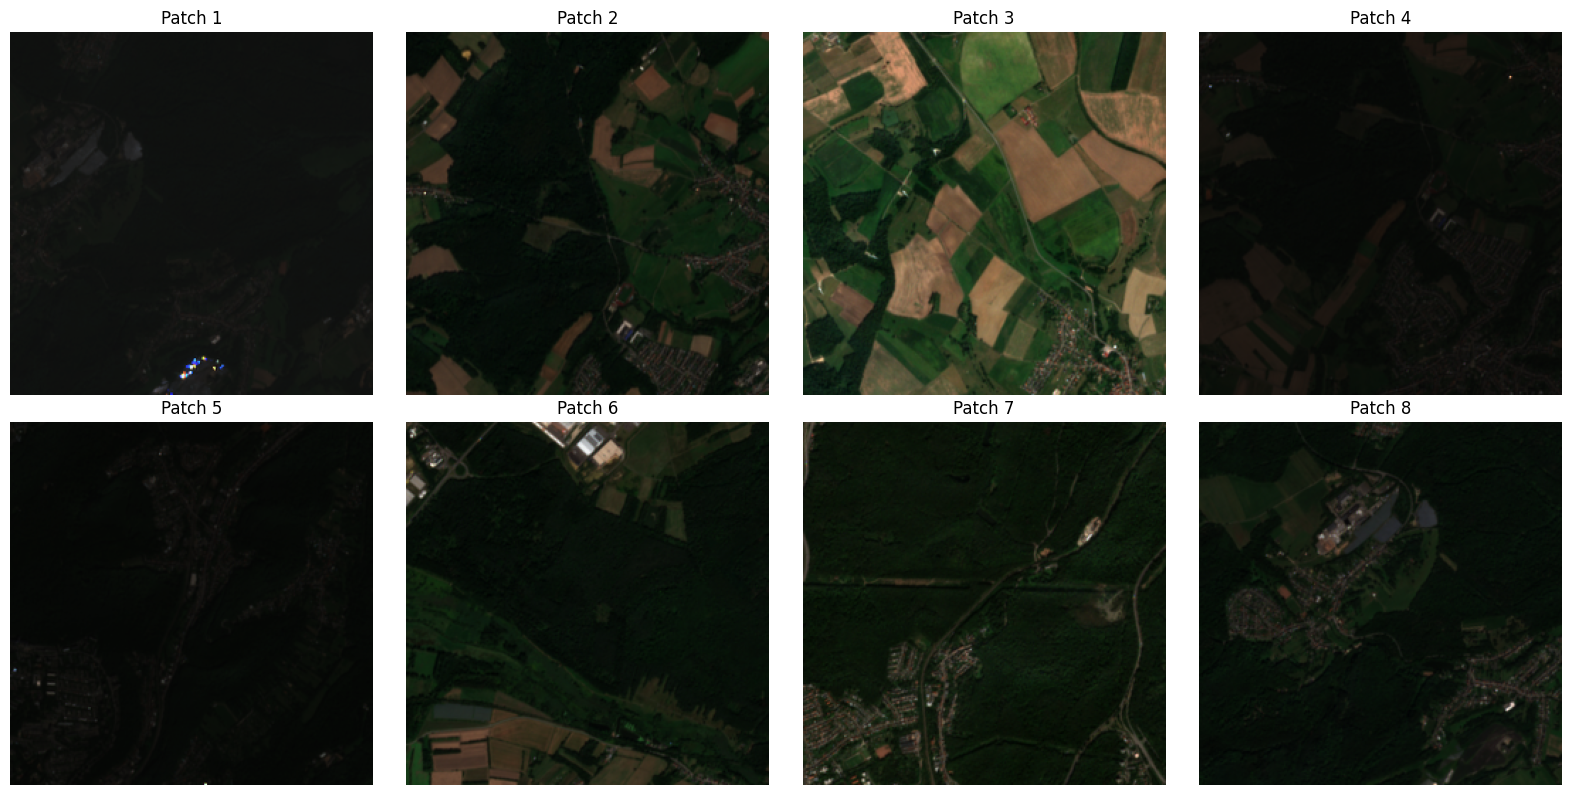

In [8]:
ds = xr.open_zarr(zarr_store)

# Show a few patches to check the image
n_chunks = 8
chunk_size =  256
max_y = ds.sizes['y'] - chunk_size
max_x = ds.sizes['x'] - chunk_size

# random top-left corners for chunks
np.random.seed(30)
ys = np.random.randint(0, max_y, n_chunks)
xs = np.random.randint(0, max_x, n_chunks)
ts = np.random.randint(0, len(ds.time), n_chunks)

# prepare figure
cols = 4
rows = n_chunks//cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, (t_idx, x_start, y_start) in enumerate(zip(ts, xs, ys)):
    r = ds['B04_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values
    g = ds['B03_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values
    b = ds['B02_10m'].isel(time=t_idx, x=slice(x_start, x_start+chunk_size), y=slice(y_start, y_start+chunk_size)).compute().values

    rgb = np.stack([r, g, b], axis=-1).astype(np.float32)

    # set contrast and normalisation
    rgb = exposure.rescale_intensity(rgb, in_range='image', out_range=(0, 1))

    # plot
    ax = axes.flat[i]
    ax.imshow(rgb)
    ax.set_title(f"Patch {i+1}")
    ax.axis("off")

# Hide unused axes
for j in range(i+1, len(axes.flat)):
    axes.flat[j].axis("off")

plt.tight_layout()
plt.show()


## Full Image
Save to tiff file for interactive check on GIS Software

In [10]:
zarr_store = '../dataset/s2_saar.zarr'
ds = xr.open_zarr(zarr_store)
ds_open = xr.open_zarr(zarr_store)
ds_open = ds_open.astype('float32')
ds = ds_open[['B04_10m', 'B03_10m', 'B02_10m']]
ds = ds.rio.write_crs("EPSG:32632")

names = [t.values.astype('datetime64[D]').astype(str)[2:].replace('-', '')+ f'_{i}' for i, t in enumerate(ds.coords['time'])]
times = len(ds.coords['time'])
img_ts = [ds.isel({'time':i}) for i in range(times)]
to_tiff = [img_t.rio.to_raster(f'../dataset/{resolution}m/saar_{name}.tif',
                               driver="GTiff",
                               compress="LZW") for img_t, name in zip(img_ts, names)]

In [11]:
zarr_store = '../dataset/s2_saar.zarr'
ds = xr.open_zarr(zarr_store)

# Preprocessing dataset
1. Reduce the same date and take median
2. Normallisation using z-score

In [12]:
store = "../dataset/s2_saar.zarr"
mean_dict = {'B02_10m': 1117.2, 'B03_10m': 1041.8, 'B04_10m': 946.5}
std_dict = {'B02_10m': 736.0, 'B03_10m': 684.8, 'B04_10m': 620.0}

ds = xr.open_zarr(store).drop_vars('spatial_ref')
ds = ds[['B04_10m', 'B03_10m', 'B02_10m' ]]

# monthly reduce on time axis. reduce each month using median
ds = ds.groupby("time.month").median()
ds = ds.chunk({"x": 256, "y": 256, "month": 1}) # re-define chunk size
ds = ds.rio.write_crs("EPSG:32632", inplace=True) # ensure coordinate projection

# normalization
norm_ds = z_score_normalisation(ds, mean_dict, std_dict)

# save the images to tiff and zarr
norm_store = './dataset/s2_norm_saar.zarr'
months = len(norm_ds['month'])
names = [f'month_{month.values}' for month in norm_ds['month']]
img_ts = [norm_ds.isel({'month':i}) for i in range(months)]
to_tiff = [img_t.rio.to_raster(f'../dataset/{resolution}m/saar_norm_{name}.tif',
                               driver="GTiff",
                               compress="LZW") for img_t, name in zip(img_ts, names)]
norm_ds.to_zarr(norm_store,
                mode="w",
                consolidated=True,
                zarr_format=2)

# Setup Loader

In [ ]:
ds = xr.open_zarr(norm_store)

# preparing the ds to data loader
ds['image'] = ds[bands].to_array(dim='band') # package selected band into one data variable
ds['image'].coords['band'] = ["B02", "B03", "B04"] # relabel bands for clarity
ds['image'] = ds['image'].transpose('band', 'x', 'y',  'month') # Reconfigure dimensions for ML-friendly shape
ds = ds.rename({'month': 'time'}) # Rename 'month' to the more standard 'time'

# Run custom dataloader
# move the CopernicusFMDataModule() to standalone script to allow more than 1 worker
data_module = CopernicusFMDataModule(train_xr_dataset=ds['image'],
                                     input_dims={'band': 3, "x": 256, "y": 256, 'time': 1},
                                     input_overlap={"x": 0, "y": 0},
                                     batch_size_gen=8,
                                     num_workers=0) 

# check the loaded data
for i, x in enumerate(data_module.train_dataloader()):
    print('iteration: ', i)
    print('shape of batch:', x.shape)
    print('percentage of invalid data: ', percentage_invalid(x))
    print()
    if i==3:
        break

iteration:  0
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  1
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  2
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

iteration:  3
shape of batch: torch.Size([8, 3, 256, 256])
percentage of invalid data:  0.0

